In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

from pytorch3d.io import load_objs_as_meshes
import torch
from pytorch3d.renderer import FoVPerspectiveCameras
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes
import torchvision.transforms.functional as TF

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/cat_statue.obj"

device = "cuda"
mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: data/meshes/cat_statue.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


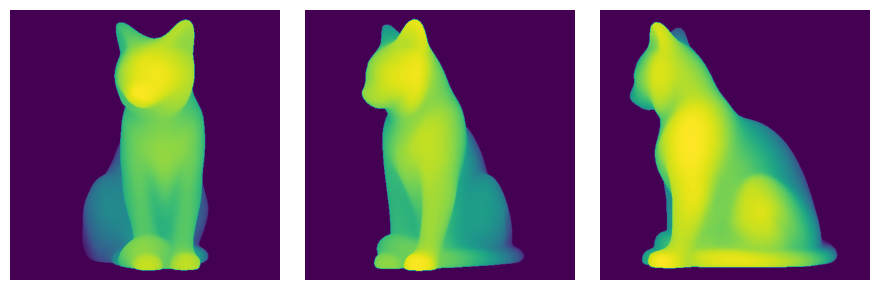

In [2]:
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_ims

n_frames = 10
dist = 6.5
angles = torch.linspace(0, 360, n_frames)
angles = angles[0:3]
R, T = turntable_extrinsics(dists=dist, angles=angles)
cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)

meshes = mesh.extend(len(cams))

display_ims(render_depth_map(meshes, cams))

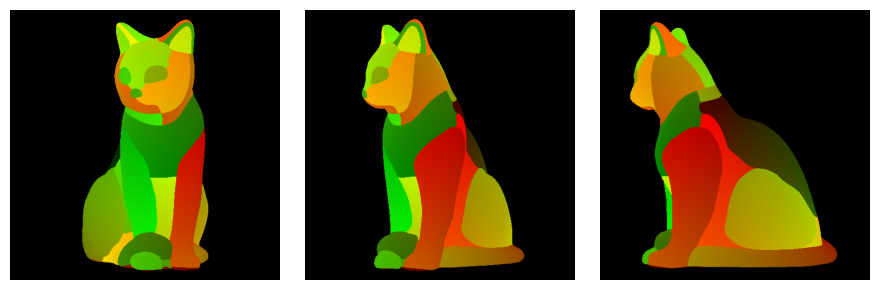

In [3]:
from text3d2video.rendering import render_rgb_uv_map


display_ims(render_rgb_uv_map(meshes, cams, verts_uvs, faces_uvs))

In [5]:
from text3d2video.rendering import make_mesh_rasterizer, compute_uv_jacobian_map

rasterizer = make_mesh_rasterizer(resolution=1000)
fragments = [rasterizer(mesh, cameras=cam) for cam in cams]

quality_maps = [
    compute_uv_jacobian_map(c, m, verts_uvs, faces_uvs) for c, m in zip(cams, meshes)
]
quality_maps = torch.stack(quality_maps)

max_percentile = torch.quantile(quality_maps, 0.95).cpu().item()
quality_maps_clamped = torch.clamp(quality_maps, 0, max_percentile)

print(quality_maps.min(), quality_maps.max())

tensor(0.) tensor(8.1378)


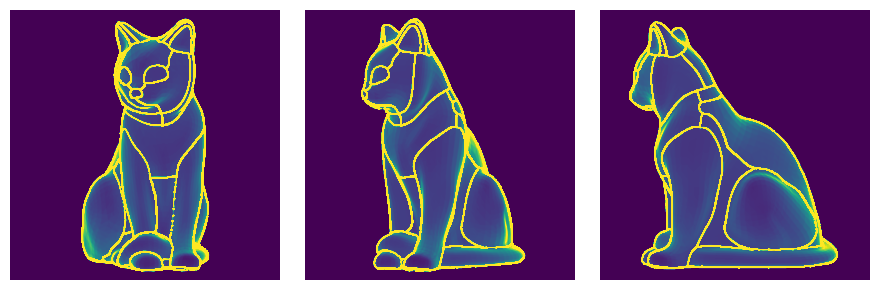

In [8]:
from matplotlib.cm import get_cmap

cmap = get_cmap('tab20')

view_indices = torch.arange(len(cams))
view_fmaps = torch.zeros_like(quality_maps)
display_ims(quality_maps, vmax=0.0005)

In [10]:
from text3d2video.backprojection import project_visible_texels_to_camera

uv_res = 512
rasterizer = make_mesh_rasterizer(resolution=512)

fragments = []
projections = []
for i in range(len(cams)):
    frags = rasterizer(meshes[i], cameras=cams[i])
    fragments.append(frags)

    proj = project_visible_texels_to_camera(
        meshes[i], cams[i], verts_uvs, faces_uvs, texture_res=uv_res, raster_res=3000
    )
    torch.cuda.empty_cache()
    projections.append(proj)

In [11]:
from text3d2video.rendering import compute_newly_visible_masks, downsample_masks


visible_masks = compute_newly_visible_masks(cams, meshes, projections, 512, 512, verts_uvs, faces_uvs)
visible_masks_down = downsample_masks(visible_masks, (64, 64))

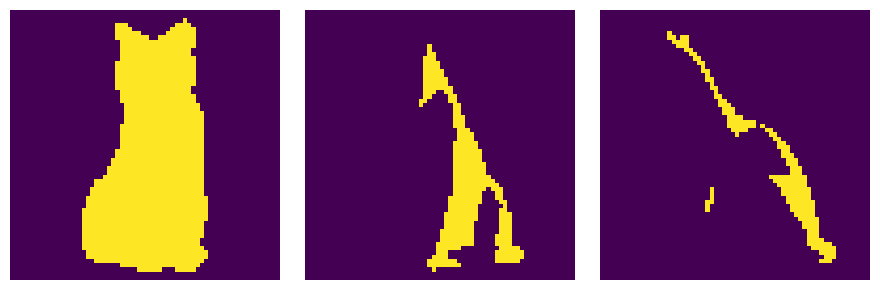

In [12]:
display_ims([TF.to_pil_image(m) for m in visible_masks_down])

# Compute Quality-based Masks
These masks should indicate which parts of the uv map we want to override. We should override if any of the following hold:

- The current texel is empty
- the current texel is populated but with a view that has lower quality

In [14]:
from text3d2video.rendering import compute_autoregressive_update_masks

better_quality_masks = compute_autoregressive_update_masks(
    cams, meshes, projections, quality_maps, 512, verts_uvs, faces_uvs, quality_factor=1
)

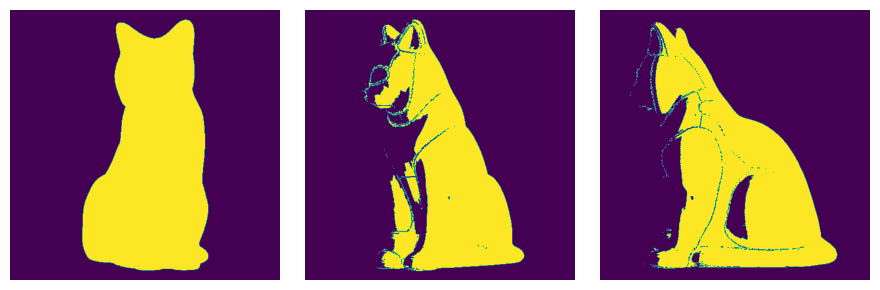

In [15]:
import torchvision.transforms.functional as TF

display_ims([TF.to_pil_image(m.float()) for m in better_quality_masks])

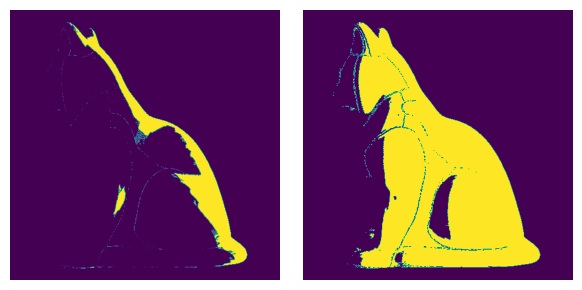

In [16]:
frame_i = 2
visible_mask = visible_masks[frame_i]
better_quality_mask = better_quality_masks[frame_i]

display_ims([visible_mask, better_quality_mask])

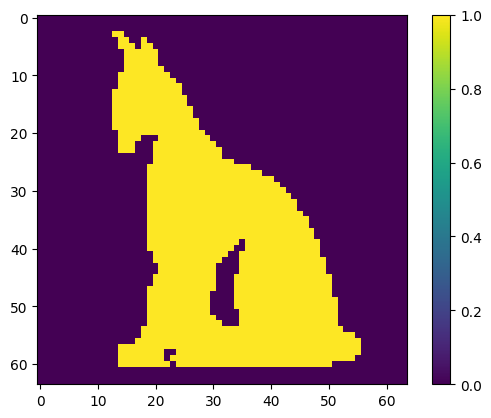

In [17]:
from matplotlib import pyplot as plt

mask = better_quality_mask

m = better_quality_mask.unsqueeze(0).unsqueeze(0).float()
m = TF.resize(m, (64, 64), interpolation=TF.InterpolationMode.BILINEAR)
m = (m > 0.5).float()
m = m[0, 0]

plt.imshow(m)
plt.colorbar()